<a href="https://colab.research.google.com/github/nedokormysh/DP_NLP_bootcamp/blob/classification/Fontanka_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Загрузка данных

In [2]:
df = pd.DataFrame()

for i in range(1, 13):
    df_ = pd.read_csv(f'https://raw.githubusercontent.com/nedokormysh/DP_NLP_bootcamp/parsing/data/fontanka_full_{i}.csv')
    df = pd.concat([df, df_])

In [3]:
df.drop_duplicates();
# df.to_csv('df_fontanka_2022.csv')

In [4]:
# Удаляем пропуски
df.dropna(inplace=True)

In [5]:
df.shape

(26515, 6)

In [6]:
# Переводим тэги к нижнему регистру
df['topic']= df['topic'].apply(lambda x: x.lower())

Изначальный анализ данных проводился на здесь https://github.com/nedokormysh/DP_NLP_bootcamp/tree/parsing

In [7]:
# Размер каждой категории
df.topic.value_counts()

общество            7341
происшествия        7248
город               4742
власть              2186
бизнес              1155
спорт                980
строительство        893
политика             598
финансы              418
авто                 265
технологии           241
туризм               128
доброе дело          117
недвижимость          86
образ жизни           50
жкх                   15
доктор питер          15
финляндия             12
новости компаний      12
особое мнение         10
работа                 3
Name: topic, dtype: int64

У нас очень мало статей по темам: жкх, доктор питер, финляндия, новости компаний, особое мнение, работа.

Для подобной несбалансированной выборки необходимо увеличивать количество данных.

Поместим эти темы в одну: "разное".

In [8]:
df['topic'] = df['topic'].apply(lambda x: 'разное' if x in ['жкх',
                                                            'доктор питер',
                                                            'финляндия',
                                                            'новости компаний',
                                                            'особое мнение',
                                                            'работа'] else x)

In [9]:
df.topic.value_counts()

общество         7341
происшествия     7248
город            4742
власть           2186
бизнес           1155
спорт             980
строительство     893
политика          598
финансы           418
авто              265
технологии        241
туризм            128
доброе дело       117
недвижимость       86
разное             67
образ жизни        50
Name: topic, dtype: int64

# Предобработка текстов.

In [10]:
RND_STATE = 7575

In [11]:
!pip install natasha -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [13]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [14]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

Функция для обработки текстов.

In [15]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [16]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: user 25min 30s, sys: 15min 32s, total: 41min 3s
Wall time: 25min 9s


Сравнение изначального текста и текста после предобработки.

In [17]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Лавров: Надеемся, что еще есть шанс вернуться к международному праву',
        'лавров надеяться шанс вернуться международный право']],
      dtype=object)

In [18]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['Роскомнадзор по требованию Генпрокуратуры ограничил доступ к сайту ежедневной немецкой газеты Die Welt, следует 10 июля из данных сервиса ведомства для проверки ограничений доступа к сайтам в Интернете.Доступ к сайту www.welt.de был ограничен в соответствии со статьей ФЗ «Об информации, информационных технологиях и о защите информации», которая регламентирует блокировку сайтов, содержащих призывы к массовым беспорядкам, экстремизму, участию в незаконных массовых акциях, а также распространяющих фейки. Die Welt — одна из крупнейших ежедневных немецких газет, ведущая газета издательской группы Axel Springer, пользующаяся популярностью у немецкой бизнес-элиты. Она писала о событиях вокруг боевых действий России на Украине, в том числе о том, как РФ обходит «нефтяные» санкции с помощью Греции.  Экс-редактор Первого канала Марина Овсянникова стала корреспондентом Die Welt после того, как выбежала в студию канала во время прямого эфира с пацифистским плакатом. Она проработала в газе

# Word2Vec

In [19]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=300,
                 min_count=10,
                 window=5,
                 seed=RND_STATE)

In [20]:
model.wv.most_similar(positive=["финляндия"])

[('страна', 0.9930151700973511),
 ('сша', 0.9921969175338745),
 ('путин', 0.9911795258522034),
 ('мид', 0.990674614906311),
 ('нато', 0.9891176819801331),
 ('заявить', 0.9890655279159546),
 ('переговоры', 0.9889297485351562),
 ('россиянин', 0.9884713292121887),
 ('российский', 0.9851127862930298),
 ('песков', 0.9843574166297913)]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=300,
                 min_count=10,
                 window=5,
                 seed=RND_STATE)

# Логистическая регрессия

## MeanEmbedding

Усредняем все слова в предложении.

In [22]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [23]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000,
                                            class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.20      0.79      0.32        58
       бизнес       0.44      0.60      0.50       277
       власть       0.42      0.41      0.41       552
        город       0.72      0.61      0.66      1182
  доброе дело       0.22      0.81      0.35        26
 недвижимость       0.23      0.68      0.34        19
  образ жизни       0.05      0.67      0.09        12
     общество       0.70      0.31      0.43      1841
     политика       0.19      0.60      0.29       134
 происшествия       0.83      0.78      0.81      1858
       разное       0.06      0.33      0.10        21
        спорт       0.83      0.94      0.88       234
строительство       0.89      0.82      0.85       216
   технологии       0.19      0.69      0.30        62
       туризм       0.10      0.75      0.18        28
      финансы       0.45      0.77      0.57       109

     accuracy                           0.58      6629
    macr

Видно, что качество определения невысокое. На мой взгляд хуже обстоят дела с точностью, чем с полнотой. При этом, если не добавлять параметр: class_weight, то мы по некоторым топикам в принципе не будем обнаруживать статьи.

## TF-IDF

In [24]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [25]:
pipe = Pipeline([('tfidf', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.23      0.81      0.36        58
       бизнес       0.43      0.58      0.50       277
       власть       0.41      0.43      0.42       552
        город       0.71      0.63      0.66      1182
  доброе дело       0.24      0.81      0.37        26
 недвижимость       0.26      0.68      0.38        19
  образ жизни       0.06      0.58      0.11        12
     общество       0.69      0.34      0.45      1841
     политика       0.19      0.57      0.28       134
 происшествия       0.83      0.78      0.81      1858
       разное       0.06      0.33      0.10        21
        спорт       0.88      0.94      0.91       234
строительство       0.89      0.88      0.89       216
   технологии       0.18      0.61      0.28        62
       туризм       0.12      0.71      0.21        28
      финансы       0.42      0.73      0.53       109

     accuracy                           0.59      6629
    macr

Качество модели улучшилось несильно. Всё также точность определения не слишком высокая.

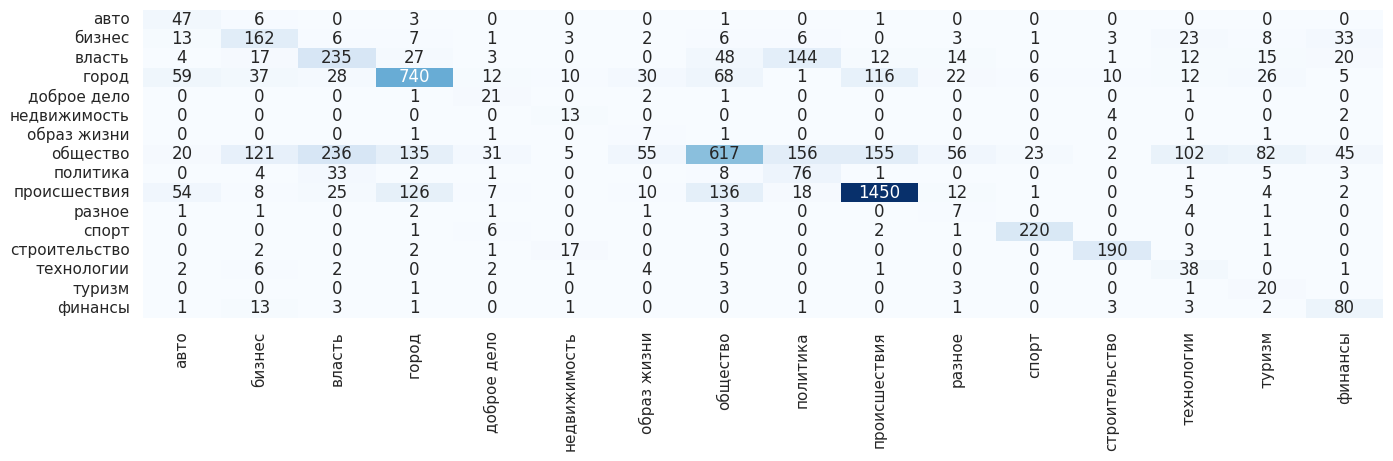

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

## FastText


In [27]:
from gensim.models.fasttext import FastText

In [28]:
model_fast = FastText(sentences=X_train,
                 vector_size=300,
                 min_count=10,
                 window=10,
                 seed=RND_STATE)

In [29]:
pipe = Pipeline([('fast', TfidfEmbeddingVectorizer(model_fast)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced'
                                            ))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.21      0.81      0.34        58
       бизнес       0.45      0.57      0.50       277
       власть       0.40      0.40      0.40       552
        город       0.71      0.60      0.65      1182
  доброе дело       0.21      0.77      0.33        26
 недвижимость       0.20      0.63      0.30        19
  образ жизни       0.01      0.17      0.03        12
     общество       0.67      0.32      0.43      1841
     политика       0.19      0.57      0.28       134
 происшествия       0.84      0.79      0.81      1858
       разное       0.08      0.57      0.13        21
        спорт       0.81      0.93      0.87       234
строительство       0.89      0.86      0.87       216
   технологии       0.19      0.63      0.30        62
       туризм       0.11      0.64      0.19        28
      финансы       0.44      0.73      0.55       109

     accuracy                           0.58      6629
    macr

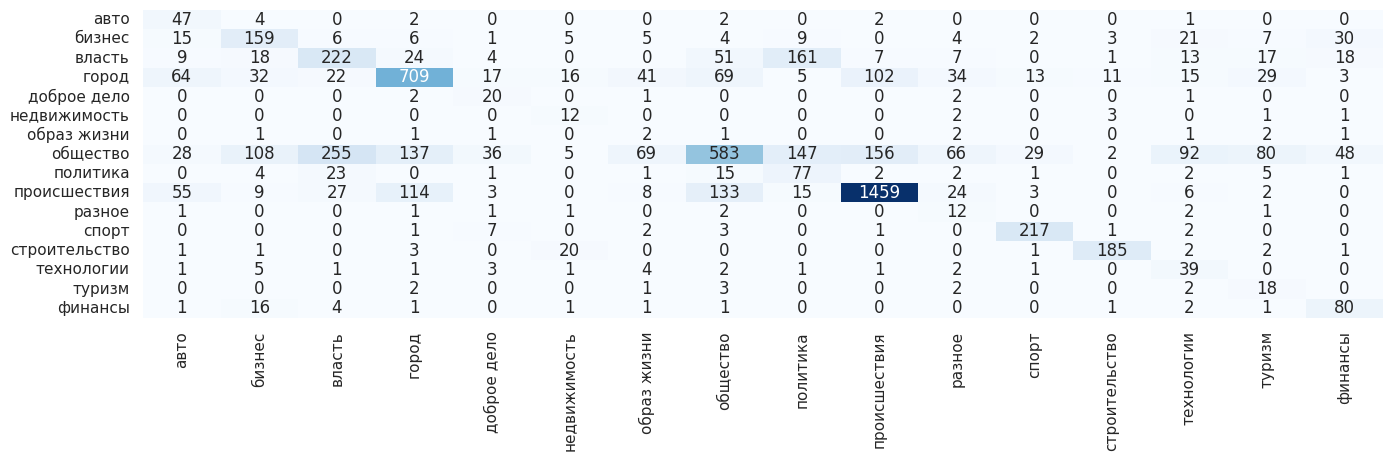

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

# SVM

In [39]:
# from sklearn.svm import NuSVC
from sklearn.svm import SVC

## MeanEmbedding

In [47]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', SVC(random_state=RND_STATE,
                             max_iter=10000,
                             class_weight='balanced'
                             ))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.28      0.81      0.42        58
       бизнес       0.41      0.66      0.51       277
       власть       0.40      0.41      0.41       552
        город       0.76      0.65      0.70      1182
  доброе дело       0.29      0.77      0.42        26
 недвижимость       0.15      0.47      0.23        19
  образ жизни       0.06      0.50      0.11        12
     общество       0.73      0.32      0.45      1841
     политика       0.18      0.60      0.28       134
 происшествия       0.83      0.86      0.84      1858
       разное       0.13      0.43      0.20        21
        спорт       0.83      0.94      0.88       234
строительство       0.89      0.82      0.85       216
   технологии       0.23      0.68      0.34        62
       туризм       0.15      0.68      0.25        28
      финансы       0.44      0.76      0.56       109

     accuracy                           0.62      6629
    macr

Рассмотрим ещё один вариант решения. Но при этом не будем использовать class_weight='balanced'.

In [48]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', SVC(random_state=RND_STATE,
                             max_iter=10000,
                            #  class_weight='balanced'
                             ))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



               precision    recall  f1-score   support

         авто       0.75      0.31      0.44        58
       бизнес       0.53      0.52      0.52       277
       власть       0.56      0.37      0.44       552
        город       0.76      0.72      0.74      1182
  доброе дело       0.70      0.54      0.61        26
 недвижимость       0.00      0.00      0.00        19
  образ жизни       0.00      0.00      0.00        12
     общество       0.60      0.72      0.65      1841
     политика       0.00      0.00      0.00       134
 происшествия       0.81      0.88      0.85      1858
       разное       0.00      0.00      0.00        21
        спорт       0.90      0.88      0.89       234
строительство       0.87      0.96      0.91       216
   технологии       0.80      0.26      0.39        62
       туризм       0.00      0.00      0.00        28
      финансы       0.67      0.51      0.58       109

     accuracy                           0.71      6629
    macr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Можно видеть, что результат ощутимо улучшился. Но при этом некоторые топики не были определены вообще.

## TF-IDF

In [45]:
pipe = Pipeline([('tfidf', TfidfEmbeddingVectorizer(model)),
                 ('clf', SVC(random_state=RND_STATE,
                               max_iter=10000,
                               class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.27      0.81      0.41        58
       бизнес       0.42      0.66      0.51       277
       власть       0.38      0.38      0.38       552
        город       0.76      0.62      0.68      1182
  доброе дело       0.30      0.88      0.45        26
 недвижимость       0.14      0.47      0.22        19
  образ жизни       0.05      0.42      0.09        12
     общество       0.73      0.33      0.45      1841
     политика       0.18      0.63      0.28       134
 происшествия       0.83      0.86      0.85      1858
       разное       0.12      0.38      0.18        21
        спорт       0.84      0.95      0.89       234
строительство       0.90      0.83      0.86       216
   технологии       0.23      0.68      0.34        62
       туризм       0.16      0.71      0.26        28
      финансы       0.42      0.75      0.54       109

     accuracy                           0.61      6629
    macr

## FastText

In [46]:
pipe = Pipeline([('fast', TfidfEmbeddingVectorizer(model_fast)),
                 ('clf', SVC(random_state=RND_STATE,
                               max_iter=10000,
                               class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.26      0.81      0.40        58
       бизнес       0.42      0.67      0.52       277
       власть       0.38      0.37      0.37       552
        город       0.74      0.63      0.68      1182
  доброе дело       0.25      0.77      0.37        26
 недвижимость       0.18      0.42      0.25        19
  образ жизни       0.03      0.17      0.04        12
     общество       0.71      0.31      0.43      1841
     политика       0.19      0.69      0.30       134
 происшествия       0.83      0.86      0.84      1858
       разное       0.14      0.38      0.21        21
        спорт       0.82      0.94      0.88       234
строительство       0.87      0.86      0.87       216
   технологии       0.20      0.60      0.30        62
       туризм       0.16      0.71      0.25        28
      финансы       0.43      0.76      0.55       109

     accuracy                           0.61      6629
    macr

# Catboost

In [49]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [50]:
from catboost import CatBoostClassifier

In [51]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            # auto_class_weights='Balanced',
                                            # loss_function='MultiClass',
                                            verbose=False))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.69      0.34      0.46        58
       бизнес       0.51      0.54      0.52       277
       власть       0.51      0.42      0.46       552
        город       0.75      0.71      0.73      1182
  доброе дело       0.70      0.62      0.65        26
 недвижимость       0.00      0.00      0.00        19
  образ жизни       0.00      0.00      0.00        12
     общество       0.60      0.68      0.64      1841
     политика       0.55      0.28      0.37       134
 происшествия       0.82      0.87      0.84      1858
       разное       0.50      0.05      0.09        21
        спорт       0.90      0.90      0.90       234
строительство       0.86      0.95      0.91       216
   технологии       0.73      0.31      0.43        62
       туризм       0.50      0.11      0.18        28
      финансы       0.60      0.47      0.53       109

     accuracy                           0.70      6629
    macr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [52]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            auto_class_weights='Balanced',
                                            # loss_function='MultiClass',
                                            verbose=False))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.43      0.64      0.51        58
       бизнес       0.43      0.70      0.54       277
       власть       0.45      0.57      0.50       552
        город       0.74      0.71      0.72      1182
  доброе дело       0.45      0.77      0.57        26
 недвижимость       0.36      0.21      0.27        19
  образ жизни       0.15      0.17      0.16        12
     общество       0.69      0.48      0.56      1841
     политика       0.30      0.46      0.36       134
 происшествия       0.83      0.86      0.84      1858
       разное       0.25      0.14      0.18        21
        спорт       0.85      0.94      0.89       234
строительство       0.87      0.96      0.92       216
   технологии       0.37      0.52      0.43        62
       туризм       0.25      0.46      0.32        28
      финансы       0.50      0.63      0.56       109

     accuracy                           0.68      6629
    macr

# Выводы

* какие-то статьи близки по тематикам (для примера: ошибки в теме строительства - статьи определялись в темах город, финансы и недвижимость)

* но больше всего на результат влияет, что данные сильно несбалансированы. На некоторые темы набралось слишком маленькое количество статей. Насколько я понял, то решением данной проблемы может быть только парсинг и скрапинг.

Впрочем, это, собственно и главный вопрос, что делать. Некоторые темы: например, особое мнение - не совсем является тематикой. А скорее отдельной рубрикой, под которой могут прятаться разные

* результаты классификаторов достаточно неважные. Важно отметить, что использовал параметр class_weight='balanced'. Иначе некоторые темы не находятся в принципе, но при этом ночность возрастает.
 * SVM оказался лучше, чем логистическая регрессия для этой задачи
 * Лучше всего себя показала модель Catboost. Но не уверен, что результаты catboost не были бы ещё лучше, если бы использовать встроенные в данный бустинг text_features.

* при этом не делался подбор гиперпараметров. Также возможно стоит попробовать ансамблирование.




Не совсем понятно, что лучше сделать в такой ситуации. Может быть объединять схожие темы? Или действительно просто набирать статьи за максимально большее количество времени? (но в исходном датасете есть тематики, где 3 статьи за год. Вероятно, что даже если набирать данные за очень большой период мы получим такой же сильно несбалансированный класс). Или пытаться строить более сложные модели?

+ не совсем ясно на чём лучше сосредоточиться: на написании бота или улучшении качества модели. Если на качестве прогнозов, то какой результат является приелемым и тогда возможно ли получить наилучший результат на логистической регрессии?

т.е. насколько понимаю, изначально нужно было добиться приемлемого качества на логистической регрессии, а использование бустингов и других механизмов возможно не приветствуется.

В общем, я немного в растерянности, что с этим делать и не знаю куда продолжать. Может быть брать другой источник данных и заново парсить данные, с учётом, что данные должны быть сбалансированы.